# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.60KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

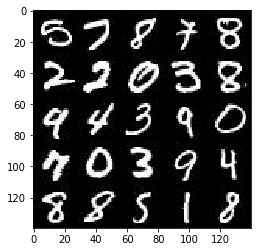

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

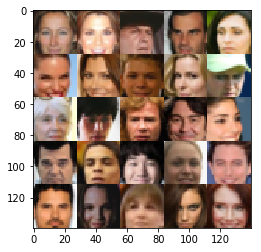

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return input, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
    # Input layer is 32x32x3
    #Defining alpha here
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat =  tf.contrib.layers.flatten(relu3) # changing tf.reshape to tf.contrib
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
    # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - 0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    # Modal input
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Modal loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Optimizing
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    n_total_batches = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            batch_counter = 0
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_counter += 1
                
                # Scaling real image values from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images*2.0
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizer
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                              input_z: batch_z,
                                              lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                #print out the stuff.
                if batch_counter % 10 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} - Batch {}/{}: ".format(e+1, epoch_count, batch_counter, n_total_batches),
                         "Discriminator loss = {:.4f} ".format(d_train_loss),
                         "Generator loss = {:.4f}".format(g_train_loss))
                    
                #Sample image
                
                if batch_counter % 100 == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 10/600:  Discriminator loss = 0.4924  Generator loss = 2.1643
Epoch 1/2 - Batch 20/600:  Discriminator loss = 0.4728  Generator loss = 2.2477
Epoch 1/2 - Batch 30/600:  Discriminator loss = 1.1189  Generator loss = 0.7878
Epoch 1/2 - Batch 40/600:  Discriminator loss = 0.6786  Generator loss = 2.2774
Epoch 1/2 - Batch 50/600:  Discriminator loss = 0.7190  Generator loss = 2.5769
Epoch 1/2 - Batch 60/600:  Discriminator loss = 0.6427  Generator loss = 1.8760
Epoch 1/2 - Batch 70/600:  Discriminator loss = 0.5078  Generator loss = 2.2786
Epoch 1/2 - Batch 80/600:  Discriminator loss = 0.5028  Generator loss = 2.2948
Epoch 1/2 - Batch 90/600:  Discriminator loss = 0.4783  Generator loss = 2.5271
Epoch 1/2 - Batch 100/600:  Discriminator loss = 0.4245  Generator loss = 3.9717


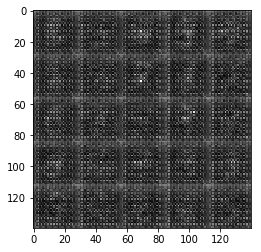

Epoch 1/2 - Batch 110/600:  Discriminator loss = 0.5557  Generator loss = 2.0708
Epoch 1/2 - Batch 120/600:  Discriminator loss = 0.6934  Generator loss = 3.7693
Epoch 1/2 - Batch 130/600:  Discriminator loss = 0.9114  Generator loss = 1.0114
Epoch 1/2 - Batch 140/600:  Discriminator loss = 0.7552  Generator loss = 3.0406
Epoch 1/2 - Batch 150/600:  Discriminator loss = 0.5252  Generator loss = 2.3252
Epoch 1/2 - Batch 160/600:  Discriminator loss = 0.7708  Generator loss = 1.3145
Epoch 1/2 - Batch 170/600:  Discriminator loss = 0.8828  Generator loss = 3.0177
Epoch 1/2 - Batch 180/600:  Discriminator loss = 0.8713  Generator loss = 1.0085
Epoch 1/2 - Batch 190/600:  Discriminator loss = 0.6601  Generator loss = 2.1725
Epoch 1/2 - Batch 200/600:  Discriminator loss = 0.7193  Generator loss = 2.6196


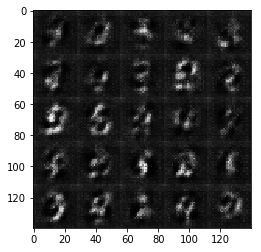

Epoch 1/2 - Batch 210/600:  Discriminator loss = 0.6696  Generator loss = 1.5500
Epoch 1/2 - Batch 220/600:  Discriminator loss = 0.8414  Generator loss = 1.1082
Epoch 1/2 - Batch 230/600:  Discriminator loss = 0.7759  Generator loss = 3.2151
Epoch 1/2 - Batch 240/600:  Discriminator loss = 0.5619  Generator loss = 2.1358
Epoch 1/2 - Batch 250/600:  Discriminator loss = 0.7893  Generator loss = 1.1274
Epoch 1/2 - Batch 260/600:  Discriminator loss = 0.5387  Generator loss = 2.5854
Epoch 1/2 - Batch 270/600:  Discriminator loss = 0.6233  Generator loss = 1.5577
Epoch 1/2 - Batch 280/600:  Discriminator loss = 0.7769  Generator loss = 1.2325
Epoch 1/2 - Batch 290/600:  Discriminator loss = 0.6323  Generator loss = 1.5099
Epoch 1/2 - Batch 300/600:  Discriminator loss = 0.9364  Generator loss = 3.9020


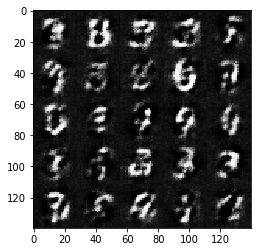

Epoch 1/2 - Batch 310/600:  Discriminator loss = 0.9153  Generator loss = 0.9381
Epoch 1/2 - Batch 320/600:  Discriminator loss = 0.5689  Generator loss = 2.6386
Epoch 1/2 - Batch 330/600:  Discriminator loss = 0.5780  Generator loss = 2.7322
Epoch 1/2 - Batch 340/600:  Discriminator loss = 0.6480  Generator loss = 1.4631
Epoch 1/2 - Batch 350/600:  Discriminator loss = 0.5496  Generator loss = 2.0105
Epoch 1/2 - Batch 360/600:  Discriminator loss = 1.6342  Generator loss = 5.0499
Epoch 1/2 - Batch 370/600:  Discriminator loss = 0.5378  Generator loss = 2.4048
Epoch 1/2 - Batch 380/600:  Discriminator loss = 0.5436  Generator loss = 2.0081
Epoch 1/2 - Batch 390/600:  Discriminator loss = 0.5304  Generator loss = 2.1522
Epoch 1/2 - Batch 400/600:  Discriminator loss = 0.5298  Generator loss = 2.3397


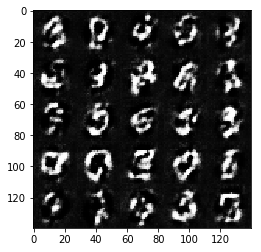

Epoch 1/2 - Batch 410/600:  Discriminator loss = 0.5934  Generator loss = 2.8139
Epoch 1/2 - Batch 420/600:  Discriminator loss = 0.6657  Generator loss = 1.4513
Epoch 1/2 - Batch 430/600:  Discriminator loss = 0.6105  Generator loss = 1.5693
Epoch 1/2 - Batch 440/600:  Discriminator loss = 0.5611  Generator loss = 2.7300
Epoch 1/2 - Batch 450/600:  Discriminator loss = 1.0642  Generator loss = 4.0712
Epoch 1/2 - Batch 460/600:  Discriminator loss = 0.6143  Generator loss = 2.6326
Epoch 1/2 - Batch 470/600:  Discriminator loss = 0.5079  Generator loss = 2.1492
Epoch 1/2 - Batch 480/600:  Discriminator loss = 0.7153  Generator loss = 1.3468
Epoch 1/2 - Batch 490/600:  Discriminator loss = 0.8323  Generator loss = 1.1670
Epoch 1/2 - Batch 500/600:  Discriminator loss = 0.5884  Generator loss = 1.7768


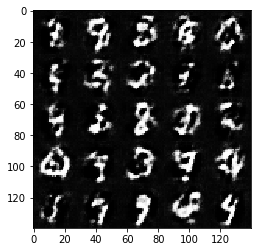

Epoch 1/2 - Batch 510/600:  Discriminator loss = 0.5996  Generator loss = 1.6696
Epoch 1/2 - Batch 520/600:  Discriminator loss = 0.5244  Generator loss = 2.1084
Epoch 1/2 - Batch 530/600:  Discriminator loss = 0.5775  Generator loss = 2.9808
Epoch 1/2 - Batch 540/600:  Discriminator loss = 0.5453  Generator loss = 2.2334
Epoch 1/2 - Batch 550/600:  Discriminator loss = 0.5849  Generator loss = 1.7327
Epoch 1/2 - Batch 560/600:  Discriminator loss = 0.5233  Generator loss = 2.2372
Epoch 1/2 - Batch 570/600:  Discriminator loss = 0.5401  Generator loss = 2.5844
Epoch 1/2 - Batch 580/600:  Discriminator loss = 0.5520  Generator loss = 2.3154
Epoch 1/2 - Batch 590/600:  Discriminator loss = 0.8461  Generator loss = 3.6279
Epoch 1/2 - Batch 600/600:  Discriminator loss = 0.8632  Generator loss = 1.0790


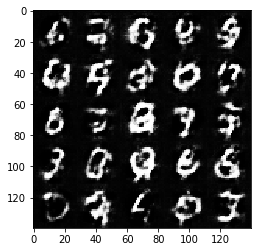

Epoch 2/2 - Batch 10/600:  Discriminator loss = 0.5418  Generator loss = 2.0491
Epoch 2/2 - Batch 20/600:  Discriminator loss = 0.5970  Generator loss = 2.8111
Epoch 2/2 - Batch 30/600:  Discriminator loss = 0.5853  Generator loss = 2.6481
Epoch 2/2 - Batch 40/600:  Discriminator loss = 0.6152  Generator loss = 1.8288
Epoch 2/2 - Batch 50/600:  Discriminator loss = 1.0201  Generator loss = 0.8580
Epoch 2/2 - Batch 60/600:  Discriminator loss = 0.5632  Generator loss = 1.8684
Epoch 2/2 - Batch 70/600:  Discriminator loss = 0.5980  Generator loss = 2.1035
Epoch 2/2 - Batch 80/600:  Discriminator loss = 0.8430  Generator loss = 1.1274
Epoch 2/2 - Batch 90/600:  Discriminator loss = 0.6349  Generator loss = 1.6852
Epoch 2/2 - Batch 100/600:  Discriminator loss = 0.6090  Generator loss = 1.7178


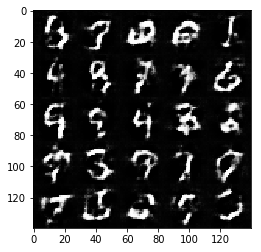

Epoch 2/2 - Batch 110/600:  Discriminator loss = 0.9941  Generator loss = 0.9040
Epoch 2/2 - Batch 120/600:  Discriminator loss = 0.7864  Generator loss = 1.2072
Epoch 2/2 - Batch 130/600:  Discriminator loss = 0.6132  Generator loss = 2.2770
Epoch 2/2 - Batch 140/600:  Discriminator loss = 0.6030  Generator loss = 1.6461
Epoch 2/2 - Batch 150/600:  Discriminator loss = 0.7855  Generator loss = 1.3064
Epoch 2/2 - Batch 160/600:  Discriminator loss = 0.6673  Generator loss = 1.4894
Epoch 2/2 - Batch 170/600:  Discriminator loss = 0.6883  Generator loss = 1.6712
Epoch 2/2 - Batch 180/600:  Discriminator loss = 0.6046  Generator loss = 2.5571
Epoch 2/2 - Batch 190/600:  Discriminator loss = 0.6321  Generator loss = 1.7755
Epoch 2/2 - Batch 200/600:  Discriminator loss = 0.7896  Generator loss = 1.1672


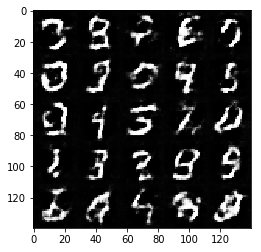

Epoch 2/2 - Batch 210/600:  Discriminator loss = 0.6910  Generator loss = 1.3929
Epoch 2/2 - Batch 220/600:  Discriminator loss = 0.6368  Generator loss = 1.9975
Epoch 2/2 - Batch 230/600:  Discriminator loss = 0.6541  Generator loss = 2.0378
Epoch 2/2 - Batch 240/600:  Discriminator loss = 1.1543  Generator loss = 3.4729
Epoch 2/2 - Batch 250/600:  Discriminator loss = 1.0580  Generator loss = 0.7997
Epoch 2/2 - Batch 260/600:  Discriminator loss = 0.6640  Generator loss = 1.9780
Epoch 2/2 - Batch 270/600:  Discriminator loss = 0.6553  Generator loss = 1.8293
Epoch 2/2 - Batch 280/600:  Discriminator loss = 0.6677  Generator loss = 1.5086
Epoch 2/2 - Batch 290/600:  Discriminator loss = 0.6797  Generator loss = 2.5453
Epoch 2/2 - Batch 300/600:  Discriminator loss = 1.4343  Generator loss = 3.7835


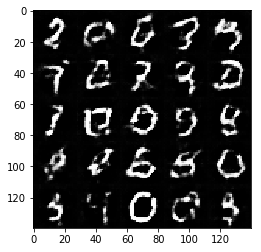

Epoch 2/2 - Batch 310/600:  Discriminator loss = 0.9193  Generator loss = 0.9851
Epoch 2/2 - Batch 320/600:  Discriminator loss = 0.7428  Generator loss = 2.0789
Epoch 2/2 - Batch 330/600:  Discriminator loss = 0.6060  Generator loss = 2.3661
Epoch 2/2 - Batch 340/600:  Discriminator loss = 0.7274  Generator loss = 2.1573
Epoch 2/2 - Batch 350/600:  Discriminator loss = 0.8054  Generator loss = 1.2236
Epoch 2/2 - Batch 360/600:  Discriminator loss = 0.7778  Generator loss = 1.9655
Epoch 2/2 - Batch 370/600:  Discriminator loss = 0.8458  Generator loss = 1.0541
Epoch 2/2 - Batch 380/600:  Discriminator loss = 0.7337  Generator loss = 1.5822
Epoch 2/2 - Batch 390/600:  Discriminator loss = 0.7071  Generator loss = 1.4278
Epoch 2/2 - Batch 400/600:  Discriminator loss = 0.6492  Generator loss = 1.6088


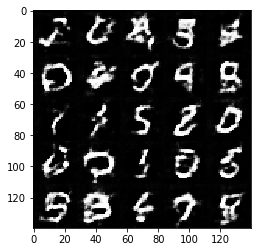

Epoch 2/2 - Batch 410/600:  Discriminator loss = 0.7208  Generator loss = 1.8201
Epoch 2/2 - Batch 420/600:  Discriminator loss = 1.0781  Generator loss = 0.7613
Epoch 2/2 - Batch 430/600:  Discriminator loss = 0.9010  Generator loss = 0.9725
Epoch 2/2 - Batch 440/600:  Discriminator loss = 0.6813  Generator loss = 1.8150
Epoch 2/2 - Batch 450/600:  Discriminator loss = 0.7141  Generator loss = 1.8424
Epoch 2/2 - Batch 460/600:  Discriminator loss = 0.8130  Generator loss = 1.7565
Epoch 2/2 - Batch 470/600:  Discriminator loss = 0.7739  Generator loss = 2.2712
Epoch 2/2 - Batch 480/600:  Discriminator loss = 1.1317  Generator loss = 0.7414
Epoch 2/2 - Batch 490/600:  Discriminator loss = 0.9082  Generator loss = 0.9814
Epoch 2/2 - Batch 500/600:  Discriminator loss = 0.9710  Generator loss = 0.8983


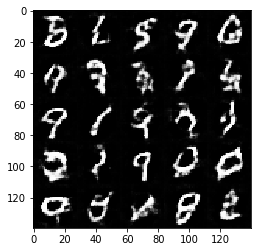

Epoch 2/2 - Batch 510/600:  Discriminator loss = 0.8942  Generator loss = 0.9828
Epoch 2/2 - Batch 520/600:  Discriminator loss = 0.7481  Generator loss = 1.2899
Epoch 2/2 - Batch 530/600:  Discriminator loss = 1.2520  Generator loss = 0.6167
Epoch 2/2 - Batch 540/600:  Discriminator loss = 0.8511  Generator loss = 2.3180
Epoch 2/2 - Batch 550/600:  Discriminator loss = 0.7419  Generator loss = 1.3515
Epoch 2/2 - Batch 560/600:  Discriminator loss = 0.6603  Generator loss = 1.8957
Epoch 2/2 - Batch 570/600:  Discriminator loss = 0.7607  Generator loss = 1.2748
Epoch 2/2 - Batch 580/600:  Discriminator loss = 0.8114  Generator loss = 1.1728
Epoch 2/2 - Batch 590/600:  Discriminator loss = 0.7658  Generator loss = 1.2861
Epoch 2/2 - Batch 600/600:  Discriminator loss = 0.7763  Generator loss = 1.2498


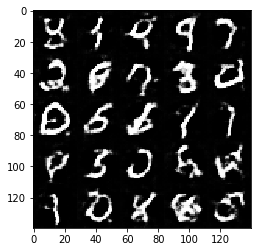

In [27]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/2025:  Discriminator loss = 0.5895  Generator loss = 2.3555
Epoch 1/1 - Batch 20/2025:  Discriminator loss = 0.4541  Generator loss = 3.2111
Epoch 1/1 - Batch 30/2025:  Discriminator loss = 0.4155  Generator loss = 6.9132
Epoch 1/1 - Batch 40/2025:  Discriminator loss = 0.7747  Generator loss = 5.0998
Epoch 1/1 - Batch 50/2025:  Discriminator loss = 0.4911  Generator loss = 2.9445
Epoch 1/1 - Batch 60/2025:  Discriminator loss = 1.0888  Generator loss = 3.1325
Epoch 1/1 - Batch 70/2025:  Discriminator loss = 1.7671  Generator loss = 0.4993
Epoch 1/1 - Batch 80/2025:  Discriminator loss = 0.7869  Generator loss = 1.8108
Epoch 1/1 - Batch 90/2025:  Discriminator loss = 1.1374  Generator loss = 0.7215
Epoch 1/1 - Batch 100/2025:  Discriminator loss = 0.9382  Generator loss = 3.4875


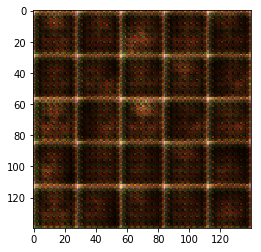

Epoch 1/1 - Batch 110/2025:  Discriminator loss = 0.8905  Generator loss = 2.4815
Epoch 1/1 - Batch 120/2025:  Discriminator loss = 0.8582  Generator loss = 1.2312
Epoch 1/1 - Batch 130/2025:  Discriminator loss = 0.9336  Generator loss = 1.0526
Epoch 1/1 - Batch 140/2025:  Discriminator loss = 0.8222  Generator loss = 2.3709
Epoch 1/1 - Batch 150/2025:  Discriminator loss = 0.8160  Generator loss = 1.4931
Epoch 1/1 - Batch 160/2025:  Discriminator loss = 0.7648  Generator loss = 1.5586
Epoch 1/1 - Batch 170/2025:  Discriminator loss = 0.8696  Generator loss = 2.3560
Epoch 1/1 - Batch 180/2025:  Discriminator loss = 0.8063  Generator loss = 1.3002
Epoch 1/1 - Batch 190/2025:  Discriminator loss = 1.3360  Generator loss = 0.6806
Epoch 1/1 - Batch 200/2025:  Discriminator loss = 1.2356  Generator loss = 0.7688


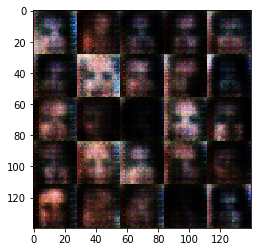

Epoch 1/1 - Batch 210/2025:  Discriminator loss = 1.0660  Generator loss = 2.7918
Epoch 1/1 - Batch 220/2025:  Discriminator loss = 0.9673  Generator loss = 1.0290
Epoch 1/1 - Batch 230/2025:  Discriminator loss = 1.0950  Generator loss = 0.8102
Epoch 1/1 - Batch 240/2025:  Discriminator loss = 0.8945  Generator loss = 1.3385
Epoch 1/1 - Batch 250/2025:  Discriminator loss = 0.9568  Generator loss = 1.9411
Epoch 1/1 - Batch 260/2025:  Discriminator loss = 1.0731  Generator loss = 1.4962
Epoch 1/1 - Batch 270/2025:  Discriminator loss = 0.9734  Generator loss = 1.1542
Epoch 1/1 - Batch 280/2025:  Discriminator loss = 1.4483  Generator loss = 2.3197
Epoch 1/1 - Batch 290/2025:  Discriminator loss = 1.1475  Generator loss = 1.1879
Epoch 1/1 - Batch 300/2025:  Discriminator loss = 0.9244  Generator loss = 1.7629


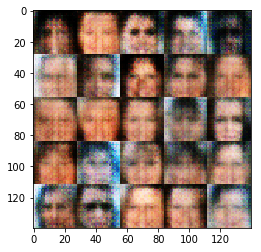

Epoch 1/1 - Batch 310/2025:  Discriminator loss = 1.4706  Generator loss = 0.4918
Epoch 1/1 - Batch 320/2025:  Discriminator loss = 0.9958  Generator loss = 1.1321
Epoch 1/1 - Batch 330/2025:  Discriminator loss = 1.0342  Generator loss = 1.2135
Epoch 1/1 - Batch 340/2025:  Discriminator loss = 1.3672  Generator loss = 0.6013
Epoch 1/1 - Batch 350/2025:  Discriminator loss = 1.1149  Generator loss = 1.3743
Epoch 1/1 - Batch 360/2025:  Discriminator loss = 1.3491  Generator loss = 0.5749
Epoch 1/1 - Batch 370/2025:  Discriminator loss = 1.0424  Generator loss = 1.5076
Epoch 1/1 - Batch 380/2025:  Discriminator loss = 0.9654  Generator loss = 1.2644
Epoch 1/1 - Batch 390/2025:  Discriminator loss = 1.4952  Generator loss = 0.4974
Epoch 1/1 - Batch 400/2025:  Discriminator loss = 1.1030  Generator loss = 0.9506


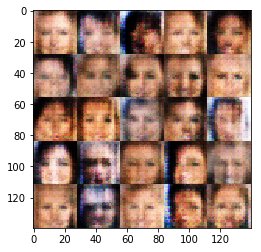

Epoch 1/1 - Batch 410/2025:  Discriminator loss = 1.0600  Generator loss = 1.3273
Epoch 1/1 - Batch 420/2025:  Discriminator loss = 1.2758  Generator loss = 1.9980
Epoch 1/1 - Batch 430/2025:  Discriminator loss = 0.9641  Generator loss = 1.1963
Epoch 1/1 - Batch 440/2025:  Discriminator loss = 1.1723  Generator loss = 0.9932
Epoch 1/1 - Batch 450/2025:  Discriminator loss = 1.0119  Generator loss = 1.2738
Epoch 1/1 - Batch 460/2025:  Discriminator loss = 1.0368  Generator loss = 1.3834
Epoch 1/1 - Batch 470/2025:  Discriminator loss = 1.0916  Generator loss = 1.5410
Epoch 1/1 - Batch 480/2025:  Discriminator loss = 1.2231  Generator loss = 1.7920
Epoch 1/1 - Batch 490/2025:  Discriminator loss = 1.2021  Generator loss = 0.7516
Epoch 1/1 - Batch 500/2025:  Discriminator loss = 1.3822  Generator loss = 0.6516


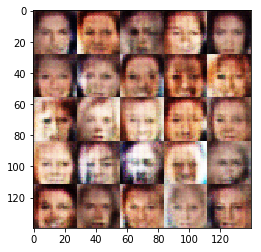

Epoch 1/1 - Batch 510/2025:  Discriminator loss = 1.1487  Generator loss = 1.3678
Epoch 1/1 - Batch 520/2025:  Discriminator loss = 1.1008  Generator loss = 1.3203
Epoch 1/1 - Batch 530/2025:  Discriminator loss = 1.1857  Generator loss = 0.8104
Epoch 1/1 - Batch 540/2025:  Discriminator loss = 1.2269  Generator loss = 0.9474
Epoch 1/1 - Batch 550/2025:  Discriminator loss = 1.2059  Generator loss = 0.7871
Epoch 1/1 - Batch 560/2025:  Discriminator loss = 0.9914  Generator loss = 1.1663
Epoch 1/1 - Batch 570/2025:  Discriminator loss = 1.1782  Generator loss = 0.6856
Epoch 1/1 - Batch 580/2025:  Discriminator loss = 1.2715  Generator loss = 1.8964
Epoch 1/1 - Batch 590/2025:  Discriminator loss = 1.2712  Generator loss = 0.6751
Epoch 1/1 - Batch 600/2025:  Discriminator loss = 1.1449  Generator loss = 1.8245


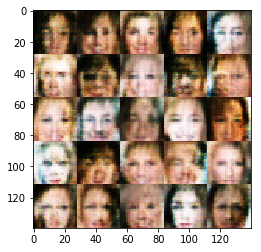

Epoch 1/1 - Batch 610/2025:  Discriminator loss = 1.5184  Generator loss = 2.3667
Epoch 1/1 - Batch 620/2025:  Discriminator loss = 1.1288  Generator loss = 1.5827
Epoch 1/1 - Batch 630/2025:  Discriminator loss = 1.1736  Generator loss = 0.7727
Epoch 1/1 - Batch 640/2025:  Discriminator loss = 1.2493  Generator loss = 0.6980
Epoch 1/1 - Batch 650/2025:  Discriminator loss = 1.2678  Generator loss = 2.1610
Epoch 1/1 - Batch 660/2025:  Discriminator loss = 1.1996  Generator loss = 0.7781
Epoch 1/1 - Batch 670/2025:  Discriminator loss = 1.0039  Generator loss = 1.5014
Epoch 1/1 - Batch 680/2025:  Discriminator loss = 0.9693  Generator loss = 1.3384
Epoch 1/1 - Batch 690/2025:  Discriminator loss = 1.2616  Generator loss = 0.7299
Epoch 1/1 - Batch 700/2025:  Discriminator loss = 1.0528  Generator loss = 1.2026


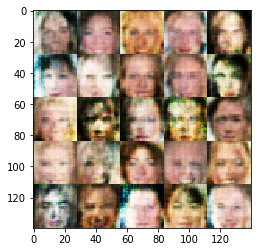

Epoch 1/1 - Batch 710/2025:  Discriminator loss = 1.2471  Generator loss = 1.2933
Epoch 1/1 - Batch 720/2025:  Discriminator loss = 1.1708  Generator loss = 0.9897
Epoch 1/1 - Batch 730/2025:  Discriminator loss = 1.1234  Generator loss = 0.8304
Epoch 1/1 - Batch 740/2025:  Discriminator loss = 1.0597  Generator loss = 0.9664
Epoch 1/1 - Batch 750/2025:  Discriminator loss = 1.2875  Generator loss = 0.7179
Epoch 1/1 - Batch 760/2025:  Discriminator loss = 1.5139  Generator loss = 0.4417
Epoch 1/1 - Batch 770/2025:  Discriminator loss = 1.1463  Generator loss = 1.0020
Epoch 1/1 - Batch 780/2025:  Discriminator loss = 1.3171  Generator loss = 0.6610
Epoch 1/1 - Batch 790/2025:  Discriminator loss = 1.0444  Generator loss = 1.0865
Epoch 1/1 - Batch 800/2025:  Discriminator loss = 1.2305  Generator loss = 0.6870


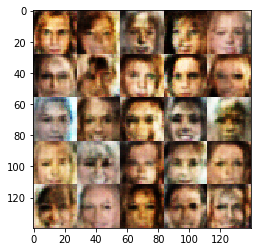

Epoch 1/1 - Batch 810/2025:  Discriminator loss = 1.1368  Generator loss = 1.7024
Epoch 1/1 - Batch 820/2025:  Discriminator loss = 0.9979  Generator loss = 1.1005
Epoch 1/1 - Batch 830/2025:  Discriminator loss = 1.1553  Generator loss = 0.8712
Epoch 1/1 - Batch 840/2025:  Discriminator loss = 0.9488  Generator loss = 1.3593
Epoch 1/1 - Batch 850/2025:  Discriminator loss = 1.0595  Generator loss = 1.1299
Epoch 1/1 - Batch 860/2025:  Discriminator loss = 0.9776  Generator loss = 1.1258
Epoch 1/1 - Batch 870/2025:  Discriminator loss = 1.1049  Generator loss = 1.1712
Epoch 1/1 - Batch 880/2025:  Discriminator loss = 1.1489  Generator loss = 0.9236
Epoch 1/1 - Batch 890/2025:  Discriminator loss = 1.2438  Generator loss = 0.6977
Epoch 1/1 - Batch 900/2025:  Discriminator loss = 1.1589  Generator loss = 0.8754


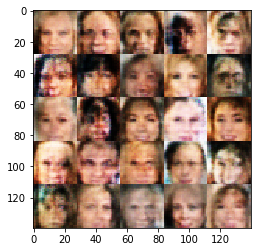

Epoch 1/1 - Batch 910/2025:  Discriminator loss = 1.1002  Generator loss = 1.1055
Epoch 1/1 - Batch 920/2025:  Discriminator loss = 1.0346  Generator loss = 1.1568
Epoch 1/1 - Batch 930/2025:  Discriminator loss = 1.2491  Generator loss = 0.7986
Epoch 1/1 - Batch 940/2025:  Discriminator loss = 1.0419  Generator loss = 1.2645
Epoch 1/1 - Batch 950/2025:  Discriminator loss = 1.0719  Generator loss = 1.0716
Epoch 1/1 - Batch 960/2025:  Discriminator loss = 1.1168  Generator loss = 1.8033
Epoch 1/1 - Batch 970/2025:  Discriminator loss = 0.9425  Generator loss = 1.0954
Epoch 1/1 - Batch 980/2025:  Discriminator loss = 1.0425  Generator loss = 0.9147
Epoch 1/1 - Batch 990/2025:  Discriminator loss = 1.4661  Generator loss = 0.4448
Epoch 1/1 - Batch 1000/2025:  Discriminator loss = 1.1959  Generator loss = 2.0941


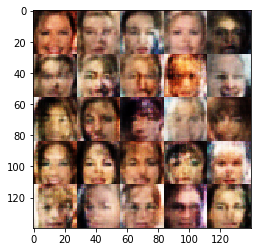

Epoch 1/1 - Batch 1010/2025:  Discriminator loss = 1.0170  Generator loss = 1.0145
Epoch 1/1 - Batch 1020/2025:  Discriminator loss = 1.0802  Generator loss = 1.7216
Epoch 1/1 - Batch 1030/2025:  Discriminator loss = 1.0234  Generator loss = 0.9748
Epoch 1/1 - Batch 1040/2025:  Discriminator loss = 1.1171  Generator loss = 1.1639
Epoch 1/1 - Batch 1050/2025:  Discriminator loss = 1.2299  Generator loss = 0.6990
Epoch 1/1 - Batch 1060/2025:  Discriminator loss = 1.0981  Generator loss = 1.0539
Epoch 1/1 - Batch 1070/2025:  Discriminator loss = 1.0826  Generator loss = 1.0997
Epoch 1/1 - Batch 1080/2025:  Discriminator loss = 1.0194  Generator loss = 1.1042
Epoch 1/1 - Batch 1090/2025:  Discriminator loss = 1.1026  Generator loss = 0.9263
Epoch 1/1 - Batch 1100/2025:  Discriminator loss = 1.0796  Generator loss = 1.8099


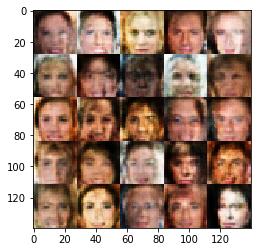

Epoch 1/1 - Batch 1110/2025:  Discriminator loss = 1.2207  Generator loss = 0.8512
Epoch 1/1 - Batch 1120/2025:  Discriminator loss = 1.2353  Generator loss = 1.9644
Epoch 1/1 - Batch 1130/2025:  Discriminator loss = 1.0159  Generator loss = 1.7061
Epoch 1/1 - Batch 1140/2025:  Discriminator loss = 0.9556  Generator loss = 1.8876
Epoch 1/1 - Batch 1150/2025:  Discriminator loss = 1.0068  Generator loss = 1.1702
Epoch 1/1 - Batch 1160/2025:  Discriminator loss = 0.8789  Generator loss = 1.1832
Epoch 1/1 - Batch 1170/2025:  Discriminator loss = 1.0205  Generator loss = 1.0997
Epoch 1/1 - Batch 1180/2025:  Discriminator loss = 1.0106  Generator loss = 1.1931
Epoch 1/1 - Batch 1190/2025:  Discriminator loss = 1.0501  Generator loss = 0.9103
Epoch 1/1 - Batch 1200/2025:  Discriminator loss = 1.0995  Generator loss = 1.5431


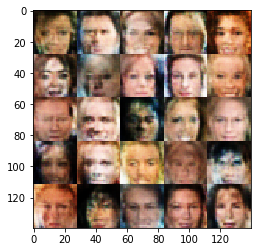

Epoch 1/1 - Batch 1210/2025:  Discriminator loss = 1.0455  Generator loss = 1.0438
Epoch 1/1 - Batch 1220/2025:  Discriminator loss = 1.1724  Generator loss = 0.6853
Epoch 1/1 - Batch 1230/2025:  Discriminator loss = 1.0210  Generator loss = 0.9158
Epoch 1/1 - Batch 1240/2025:  Discriminator loss = 1.3517  Generator loss = 0.5466
Epoch 1/1 - Batch 1250/2025:  Discriminator loss = 1.1427  Generator loss = 0.9040
Epoch 1/1 - Batch 1260/2025:  Discriminator loss = 1.0796  Generator loss = 1.4342
Epoch 1/1 - Batch 1270/2025:  Discriminator loss = 0.8664  Generator loss = 2.0883
Epoch 1/1 - Batch 1280/2025:  Discriminator loss = 0.9576  Generator loss = 1.4244
Epoch 1/1 - Batch 1290/2025:  Discriminator loss = 1.0089  Generator loss = 0.9678
Epoch 1/1 - Batch 1300/2025:  Discriminator loss = 0.8566  Generator loss = 1.3655


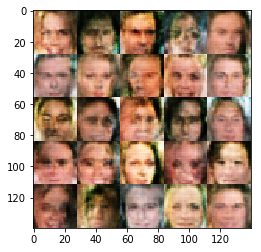

Epoch 1/1 - Batch 1310/2025:  Discriminator loss = 1.2792  Generator loss = 0.6530
Epoch 1/1 - Batch 1320/2025:  Discriminator loss = 1.0232  Generator loss = 0.8643
Epoch 1/1 - Batch 1330/2025:  Discriminator loss = 1.0529  Generator loss = 1.3135
Epoch 1/1 - Batch 1340/2025:  Discriminator loss = 1.2897  Generator loss = 0.5889
Epoch 1/1 - Batch 1350/2025:  Discriminator loss = 1.1092  Generator loss = 0.8783
Epoch 1/1 - Batch 1360/2025:  Discriminator loss = 1.0359  Generator loss = 1.1407
Epoch 1/1 - Batch 1370/2025:  Discriminator loss = 0.9757  Generator loss = 1.5610
Epoch 1/1 - Batch 1380/2025:  Discriminator loss = 1.1142  Generator loss = 1.1663
Epoch 1/1 - Batch 1390/2025:  Discriminator loss = 1.0965  Generator loss = 0.8490
Epoch 1/1 - Batch 1400/2025:  Discriminator loss = 1.1174  Generator loss = 1.4525


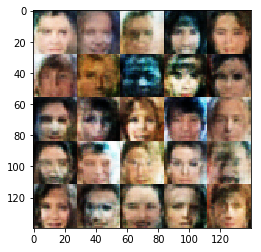

Epoch 1/1 - Batch 1410/2025:  Discriminator loss = 1.0152  Generator loss = 1.0121
Epoch 1/1 - Batch 1420/2025:  Discriminator loss = 1.3795  Generator loss = 0.5034
Epoch 1/1 - Batch 1430/2025:  Discriminator loss = 1.2768  Generator loss = 0.5884
Epoch 1/1 - Batch 1440/2025:  Discriminator loss = 1.1495  Generator loss = 0.7292
Epoch 1/1 - Batch 1450/2025:  Discriminator loss = 0.8921  Generator loss = 1.2691
Epoch 1/1 - Batch 1460/2025:  Discriminator loss = 1.2030  Generator loss = 0.6558
Epoch 1/1 - Batch 1470/2025:  Discriminator loss = 1.0284  Generator loss = 1.2071
Epoch 1/1 - Batch 1480/2025:  Discriminator loss = 0.8002  Generator loss = 1.4745
Epoch 1/1 - Batch 1490/2025:  Discriminator loss = 1.3768  Generator loss = 0.5815
Epoch 1/1 - Batch 1500/2025:  Discriminator loss = 1.1006  Generator loss = 0.9820


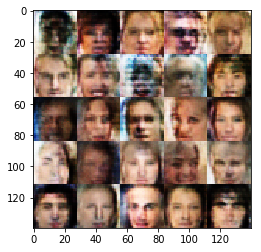

Epoch 1/1 - Batch 1510/2025:  Discriminator loss = 1.5913  Generator loss = 0.4095
Epoch 1/1 - Batch 1520/2025:  Discriminator loss = 0.9391  Generator loss = 1.2318
Epoch 1/1 - Batch 1530/2025:  Discriminator loss = 1.1899  Generator loss = 0.7222
Epoch 1/1 - Batch 1540/2025:  Discriminator loss = 1.0914  Generator loss = 0.8789
Epoch 1/1 - Batch 1550/2025:  Discriminator loss = 1.0492  Generator loss = 0.9830
Epoch 1/1 - Batch 1560/2025:  Discriminator loss = 0.9119  Generator loss = 1.2347
Epoch 1/1 - Batch 1570/2025:  Discriminator loss = 0.9790  Generator loss = 1.4539
Epoch 1/1 - Batch 1580/2025:  Discriminator loss = 1.0095  Generator loss = 0.9140
Epoch 1/1 - Batch 1590/2025:  Discriminator loss = 0.9807  Generator loss = 1.1458
Epoch 1/1 - Batch 1600/2025:  Discriminator loss = 1.0982  Generator loss = 0.8721


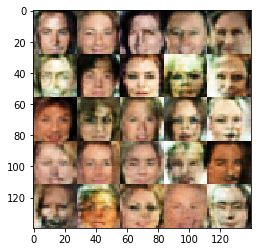

Epoch 1/1 - Batch 1610/2025:  Discriminator loss = 1.1174  Generator loss = 0.7889
Epoch 1/1 - Batch 1620/2025:  Discriminator loss = 1.1057  Generator loss = 0.7987
Epoch 1/1 - Batch 1630/2025:  Discriminator loss = 1.0138  Generator loss = 0.9393
Epoch 1/1 - Batch 1640/2025:  Discriminator loss = 0.9738  Generator loss = 1.0566
Epoch 1/1 - Batch 1650/2025:  Discriminator loss = 1.0103  Generator loss = 1.3031
Epoch 1/1 - Batch 1660/2025:  Discriminator loss = 1.3768  Generator loss = 0.5366
Epoch 1/1 - Batch 1670/2025:  Discriminator loss = 0.9782  Generator loss = 0.9041
Epoch 1/1 - Batch 1680/2025:  Discriminator loss = 1.0800  Generator loss = 0.8976
Epoch 1/1 - Batch 1690/2025:  Discriminator loss = 1.0687  Generator loss = 1.0965
Epoch 1/1 - Batch 1700/2025:  Discriminator loss = 1.2198  Generator loss = 1.8387


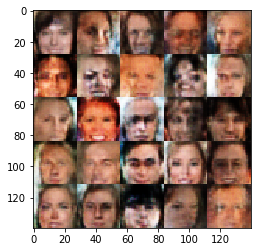

Epoch 1/1 - Batch 1710/2025:  Discriminator loss = 1.0592  Generator loss = 1.3348
Epoch 1/1 - Batch 1720/2025:  Discriminator loss = 0.8511  Generator loss = 1.2167
Epoch 1/1 - Batch 1730/2025:  Discriminator loss = 1.0073  Generator loss = 1.5346
Epoch 1/1 - Batch 1740/2025:  Discriminator loss = 1.4137  Generator loss = 0.4951
Epoch 1/1 - Batch 1750/2025:  Discriminator loss = 0.9577  Generator loss = 1.8038
Epoch 1/1 - Batch 1760/2025:  Discriminator loss = 0.9333  Generator loss = 1.2839
Epoch 1/1 - Batch 1770/2025:  Discriminator loss = 0.9121  Generator loss = 1.4991
Epoch 1/1 - Batch 1780/2025:  Discriminator loss = 1.0546  Generator loss = 0.9608
Epoch 1/1 - Batch 1790/2025:  Discriminator loss = 0.9882  Generator loss = 0.9577
Epoch 1/1 - Batch 1800/2025:  Discriminator loss = 0.9915  Generator loss = 1.8680


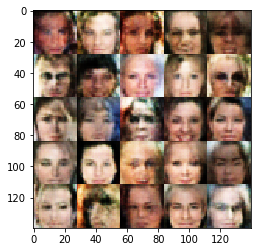

Epoch 1/1 - Batch 1810/2025:  Discriminator loss = 1.0403  Generator loss = 1.9761
Epoch 1/1 - Batch 1820/2025:  Discriminator loss = 1.1328  Generator loss = 1.5185
Epoch 1/1 - Batch 1830/2025:  Discriminator loss = 0.9133  Generator loss = 1.1456
Epoch 1/1 - Batch 1840/2025:  Discriminator loss = 1.0430  Generator loss = 1.0302
Epoch 1/1 - Batch 1850/2025:  Discriminator loss = 0.9733  Generator loss = 1.2073
Epoch 1/1 - Batch 1860/2025:  Discriminator loss = 0.8976  Generator loss = 1.6372
Epoch 1/1 - Batch 1870/2025:  Discriminator loss = 1.2639  Generator loss = 0.6134
Epoch 1/1 - Batch 1880/2025:  Discriminator loss = 0.9821  Generator loss = 0.9156
Epoch 1/1 - Batch 1890/2025:  Discriminator loss = 1.1980  Generator loss = 0.6335
Epoch 1/1 - Batch 1900/2025:  Discriminator loss = 0.9975  Generator loss = 1.6415


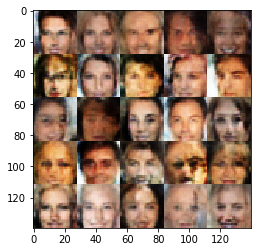

Epoch 1/1 - Batch 1910/2025:  Discriminator loss = 0.9557  Generator loss = 1.0049
Epoch 1/1 - Batch 1920/2025:  Discriminator loss = 1.3122  Generator loss = 0.5512
Epoch 1/1 - Batch 1930/2025:  Discriminator loss = 0.8852  Generator loss = 1.1390
Epoch 1/1 - Batch 1940/2025:  Discriminator loss = 1.1192  Generator loss = 0.9415
Epoch 1/1 - Batch 1950/2025:  Discriminator loss = 1.2049  Generator loss = 1.1294
Epoch 1/1 - Batch 1960/2025:  Discriminator loss = 0.8600  Generator loss = 1.2909
Epoch 1/1 - Batch 1970/2025:  Discriminator loss = 0.8720  Generator loss = 1.7196
Epoch 1/1 - Batch 1980/2025:  Discriminator loss = 1.1481  Generator loss = 0.7805
Epoch 1/1 - Batch 1990/2025:  Discriminator loss = 0.8540  Generator loss = 1.2905
Epoch 1/1 - Batch 2000/2025:  Discriminator loss = 1.0341  Generator loss = 1.0083


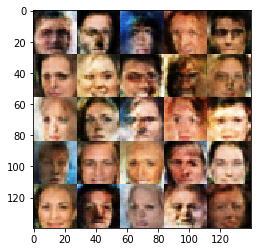

Epoch 1/1 - Batch 2010/2025:  Discriminator loss = 1.1735  Generator loss = 0.9861
Epoch 1/1 - Batch 2020/2025:  Discriminator loss = 0.9902  Generator loss = 0.9778


In [28]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.